In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [7]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = InceptionResNetV2(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 3144 samples, validate on 787 samples
Epoch 1/100
3144/3144 [==============================] - 64s 20ms/step - loss: 0.4234 - acc: 0.8702 - val_loss: 0.5081 - val_acc: 0.8094
Epoch 2/100
3144/3144 [==============================] - 51s 16ms/step - loss: 0.1965 - acc: 0.9297 - val_loss: 0.2205 - val_acc: 0.9149
Epoch 3/100
3144/3144 [==============================] - 52s 16ms/step - loss: 0.1906 - acc: 0.9370 - val_loss: 0.3726 - val_acc: 0.8590
Epoch 4/100
3144/3144 [==============================] - 53s 17ms/step - loss: 0.1429 - acc: 0.9542 - val_loss: 0.5788 - val_acc: 0.9161
Epoch 5/100
3144/3144 [==============================] - 52s 17ms/step - loss: 0.1551 - acc: 0.9472 - val_loss: 0.5455 - val_acc: 0.8310
Epoch 6/100
3144/3144 [==============================] - 52s 17ms/step - loss: 0.1156 - acc: 0.9628 - val_loss: 0.6782 - val_acc: 0.6963
Epoch 7/100
3144/3144 [==============================] - 52s 17ms/step - loss: 0.0980 - acc: 0.9691 - val_loss: 0.1581 - val_acc: 0

3144/3144 [==============================] - 52s 17ms/step - loss: 0.0111 - acc: 0.9968 - val_loss: 0.3147 - val_acc: 0.9174
Epoch 61/100
3144/3144 [==============================] - 52s 17ms/step - loss: 0.0355 - acc: 0.9860 - val_loss: 0.3270 - val_acc: 0.7865
Epoch 62/100
3144/3144 [==============================] - 52s 17ms/step - loss: 0.0149 - acc: 0.9952 - val_loss: 0.3020 - val_acc: 0.9250
Epoch 63/100
3144/3144 [==============================] - 52s 17ms/step - loss: 0.0106 - acc: 0.9959 - val_loss: 0.1494 - val_acc: 0.9682
Epoch 64/100
3144/3144 [==============================] - 52s 17ms/step - loss: 0.0302 - acc: 0.9914 - val_loss: 0.1613 - val_acc: 0.9682
Epoch 65/100
3144/3144 [==============================] - 52s 17ms/step - loss: 0.0062 - acc: 0.9978 - val_loss: 0.1784 - val_acc: 0.9657
Epoch 66/100
3144/3144 [==============================] - 52s 17ms/step - loss: 0.0061 - acc: 0.9981 - val_loss: 0.1726 - val_acc: 0.9632
Epoch 67/100
3144/3144 [=======================

3145/3145 [==============================] - 52s 17ms/step - loss: 0.1423 - acc: 0.9533 - val_loss: 0.1587 - val_acc: 0.9517
Epoch 19/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.1857 - acc: 0.9399 - val_loss: 0.3317 - val_acc: 0.8766
Epoch 20/100
3145/3145 [==============================] - 53s 17ms/step - loss: 0.1536 - acc: 0.9507 - val_loss: 0.1744 - val_acc: 0.9427
Epoch 21/100
3145/3145 [==============================] - 53s 17ms/step - loss: 0.1276 - acc: 0.9587 - val_loss: 0.1665 - val_acc: 0.9542
Epoch 22/100
3145/3145 [==============================] - 52s 16ms/step - loss: 0.1237 - acc: 0.9618 - val_loss: 0.3608 - val_acc: 0.9160
Epoch 23/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.1179 - acc: 0.9628 - val_loss: 0.1689 - val_acc: 0.9593
Epoch 24/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.1004 - acc: 0.9663 - val_loss: 0.1778 - val_acc: 0.9567
Epoch 25/100
3145/3145 [=======================

3145/3145 [==============================] - 52s 17ms/step - loss: 0.0150 - acc: 0.9949 - val_loss: 0.2053 - val_acc: 0.9644
Epoch 78/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0263 - acc: 0.9924 - val_loss: 0.1554 - val_acc: 0.9746
Epoch 79/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0065 - acc: 0.9971 - val_loss: 0.2074 - val_acc: 0.9720
Epoch 80/100
3145/3145 [==============================] - 53s 17ms/step - loss: 0.0201 - acc: 0.9930 - val_loss: 0.2096 - val_acc: 0.9644
Epoch 81/100
3145/3145 [==============================] - 53s 17ms/step - loss: 0.0132 - acc: 0.9949 - val_loss: 0.1785 - val_acc: 0.9733
Epoch 82/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0072 - acc: 0.9975 - val_loss: 0.1989 - val_acc: 0.9631
Epoch 83/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0198 - acc: 0.9927 - val_loss: 0.2794 - val_acc: 0.9580
Epoch 84/100
3145/3145 [=======================

3145/3145 [==============================] - 52s 17ms/step - loss: 0.0304 - acc: 0.9908 - val_loss: 0.2860 - val_acc: 0.9529
Epoch 36/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0318 - acc: 0.9895 - val_loss: 0.1871 - val_acc: 0.9644
Epoch 37/100
3145/3145 [==============================] - 52s 16ms/step - loss: 0.0210 - acc: 0.9927 - val_loss: 0.3591 - val_acc: 0.8982
Epoch 38/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0330 - acc: 0.9889 - val_loss: 0.2101 - val_acc: 0.9491
Epoch 39/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0763 - acc: 0.9828 - val_loss: 0.1545 - val_acc: 0.9644
Epoch 40/100
3145/3145 [==============================] - 52s 16ms/step - loss: 0.0152 - acc: 0.9952 - val_loss: 0.2453 - val_acc: 0.9402
Epoch 41/100
3145/3145 [==============================] - 53s 17ms/step - loss: 0.0092 - acc: 0.9962 - val_loss: 0.7749 - val_acc: 0.8117
Epoch 42/100
3145/3145 [=======================

3145/3145 [==============================] - 52s 17ms/step - loss: 0.0027 - acc: 0.9990 - val_loss: 0.1588 - val_acc: 0.9707
Epoch 95/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0019 - acc: 0.9997 - val_loss: 0.1987 - val_acc: 0.9580
Epoch 96/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0168 - acc: 0.9936 - val_loss: 0.8245 - val_acc: 0.8384
Epoch 97/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0035 - acc: 0.9990 - val_loss: 0.1758 - val_acc: 0.9631
Epoch 98/100
3145/3145 [==============================] - 52s 16ms/step - loss: 0.0166 - acc: 0.9949 - val_loss: 0.4156 - val_acc: 0.9148
Epoch 99/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0106 - acc: 0.9971 - val_loss: 0.3762 - val_acc: 0.9059
Epoch 100/100
786/786 [==============================] - 4s 5ms/step
[2] Test acurracy: 0.9593 (5218.4845 s)
Train on 3145 samples, validate on 786 samples
Epoch 1/100
3145/3145 [======

3145/3145 [==============================] - 52s 17ms/step - loss: 0.0253 - acc: 0.9911 - val_loss: 0.3803 - val_acc: 0.9427
Epoch 53/100
3145/3145 [==============================] - 53s 17ms/step - loss: 0.0111 - acc: 0.9962 - val_loss: 0.2539 - val_acc: 0.9542
Epoch 54/100
3145/3145 [==============================] - 53s 17ms/step - loss: 0.0238 - acc: 0.9921 - val_loss: 0.4203 - val_acc: 0.9249
Epoch 55/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0268 - acc: 0.9911 - val_loss: 0.2375 - val_acc: 0.9542
Epoch 56/100
3145/3145 [==============================] - 52s 16ms/step - loss: 0.0265 - acc: 0.9921 - val_loss: 0.2576 - val_acc: 0.9529
Epoch 57/100
3145/3145 [==============================] - 53s 17ms/step - loss: 0.0378 - acc: 0.9857 - val_loss: 0.3235 - val_acc: 0.9364
Epoch 58/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0115 - acc: 0.9965 - val_loss: 0.2671 - val_acc: 0.9618
Epoch 59/100
3145/3145 [=======================

3145/3145 [==============================] - 52s 17ms/step - loss: 0.1571 - acc: 0.9504 - val_loss: 0.4368 - val_acc: 0.8511
Epoch 11/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.1221 - acc: 0.9625 - val_loss: 1.0049 - val_acc: 0.6527
Epoch 12/100
3145/3145 [==============================] - 52s 16ms/step - loss: 0.1272 - acc: 0.9596 - val_loss: 0.2008 - val_acc: 0.9440
Epoch 13/100
3145/3145 [==============================] - 53s 17ms/step - loss: 0.1168 - acc: 0.9660 - val_loss: 1.4537 - val_acc: 0.6628
Epoch 14/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.1068 - acc: 0.9672 - val_loss: 0.2736 - val_acc: 0.9008
Epoch 15/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0979 - acc: 0.9685 - val_loss: 0.6468 - val_acc: 0.8117
Epoch 16/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0903 - acc: 0.9682 - val_loss: 0.1570 - val_acc: 0.9491
Epoch 17/100
3145/3145 [=======================

3145/3145 [==============================] - 52s 17ms/step - loss: 0.0194 - acc: 0.9930 - val_loss: 0.2222 - val_acc: 0.9593
Epoch 70/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0469 - acc: 0.9851 - val_loss: 0.2773 - val_acc: 0.9529
Epoch 71/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0031 - acc: 0.9994 - val_loss: 0.2287 - val_acc: 0.9669
Epoch 72/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.2565 - val_acc: 0.9529
Epoch 73/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0231 - acc: 0.9933 - val_loss: 0.5865 - val_acc: 0.9135
Epoch 74/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0046 - acc: 0.9987 - val_loss: 0.4303 - val_acc: 0.9160
Epoch 75/100
3145/3145 [==============================] - 52s 17ms/step - loss: 0.0140 - acc: 0.9962 - val_loss: 1.3767 - val_acc: 0.7137
Epoch 76/100
3145/3145 [=======================

In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9547


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

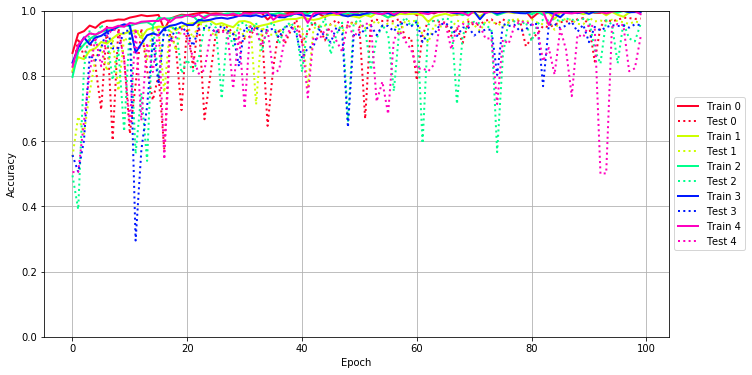

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

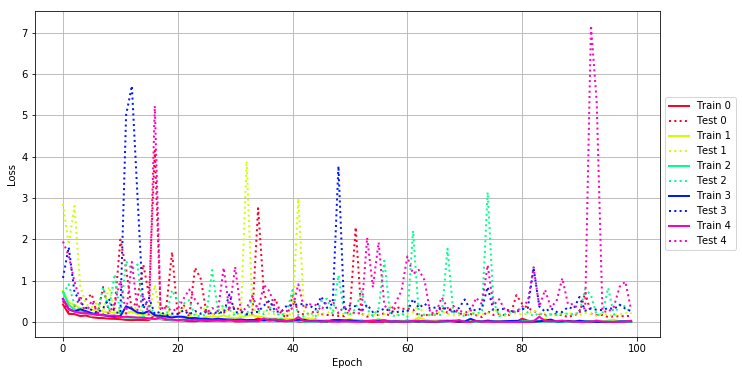

In [12]:
plot_loss(history)

Plotting the confusion matrix


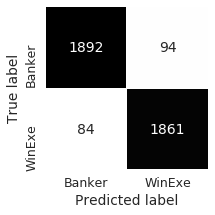

In [13]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


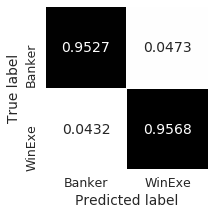

In [14]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix

figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.4f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [15]:
for h in history:
    print(h.history)

{'acc': [0.8702290076335878, 0.92970737913486, 0.9370229007633588, 0.9541984732824428, 0.9472010178117048, 0.9627862595419847, 0.969147582697201, 0.969147582697201, 0.9729643765903307, 0.9720101781170484, 0.9786895674300254, 0.9821882951653944, 0.986323155216285, 0.9831424936386769, 0.9847328244274809, 0.9869592875318066, 0.9421119592875318, 0.9751908396946565, 0.9818702290076335, 0.9875954198473282, 0.9860050890585241, 0.9895038167938931, 0.9923664122137404, 0.9949109414758269, 0.9904580152671756, 0.9917302798982188, 0.9907760814249363, 0.9869592875318066, 0.9872773536895675, 0.9840966921119593, 0.9955470737913485, 0.9933206106870229, 0.9926844783715013, 0.9920483460559797, 0.97264631043257, 0.9879134860050891, 0.9825063613231552, 0.9914122137404581, 0.9936386768447837, 0.996501272264631, 0.9872773536895675, 0.9968193384223919, 0.9984096692111959, 0.989821882951654, 0.9802798982188295, 0.996501272264631, 0.9958651399491094, 0.9952290076335878, 0.9888676844783715, 0.9958651399491094, 0

In [16]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

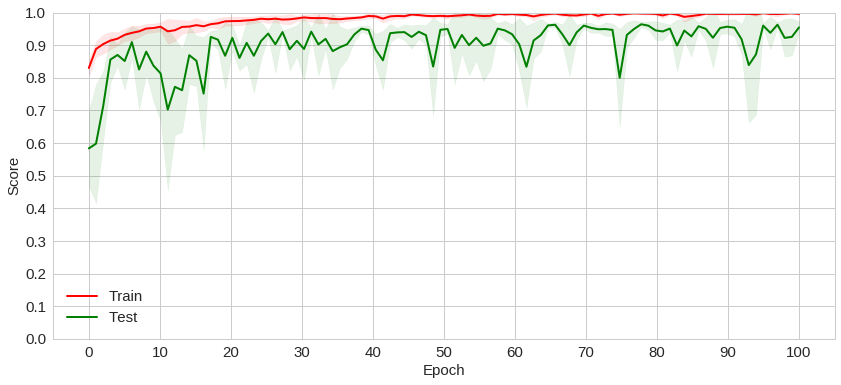

In [17]:
plot_mean_acc(history)

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

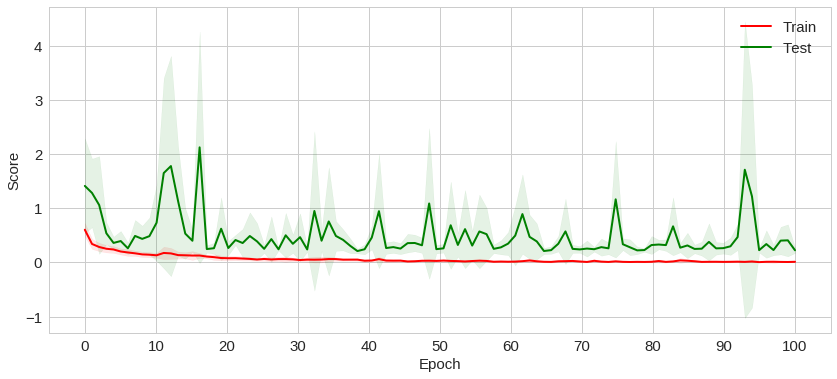

In [19]:
plot_mean_loss(history)

In [21]:
hist = [{'acc': [0.8702290076335878, 0.92970737913486, 0.9370229007633588, 0.9541984732824428, 0.9472010178117048, 0.9627862595419847, 0.969147582697201, 0.969147582697201, 0.9729643765903307, 0.9720101781170484, 0.9786895674300254, 0.9821882951653944, 0.986323155216285, 0.9831424936386769, 0.9847328244274809, 0.9869592875318066, 0.9421119592875318, 0.9751908396946565, 0.9818702290076335, 0.9875954198473282, 0.9860050890585241, 0.9895038167938931, 0.9923664122137404, 0.9949109414758269, 0.9904580152671756, 0.9917302798982188, 0.9907760814249363, 0.9869592875318066, 0.9872773536895675, 0.9840966921119593, 0.9955470737913485, 0.9933206106870229, 0.9926844783715013, 0.9920483460559797, 0.97264631043257, 0.9879134860050891, 0.9825063613231552, 0.9914122137404581, 0.9936386768447837, 0.996501272264631, 0.9872773536895675, 0.9968193384223919, 0.9984096692111959, 0.989821882951654, 0.9802798982188295, 0.996501272264631, 0.9958651399491094, 0.9952290076335878, 0.9888676844783715, 0.9958651399491094, 0.9872773536895675, 0.9866412213740458, 0.9930025445292621, 0.9990458015267175, 0.9996819338422391, 0.9996819338422391, 0.9990458015267175, 0.9996819338422391, 0.9987277353689568, 0.9968193384223919, 0.9860050890585241, 0.9952290076335878, 0.9958651399491094, 0.9914122137404581, 0.9977735368956743, 0.9980916030534351, 0.9955470737913485, 0.9872773536895675, 0.9952290076335878, 0.9987277353689568, 0.9993638676844784, 0.9961832061068703, 0.9974554707379135, 0.9980916030534351, 0.9993638676844784, 0.9996819338422391, 0.9996819338422391, 1.0, 1.0, 0.9984096692111959, 0.9764631043256997, 0.9914122137404581, 0.9949109414758269, 0.9936386768447837, 0.9961832061068703, 0.9939567430025446, 0.9984096692111959, 0.9980916030534351, 0.9990458015267175, 1.0, 0.9987277353689568, 0.9930025445292621, 0.9933206106870229, 0.9977735368956743, 0.9984096692111959, 1.0, 1.0, 1.0, 1.0, 1.0], 'val_acc': [0.8094027959558228, 0.914866582108271, 0.858958069675305, 0.9161372299872935, 0.8310038119440915, 0.6963151212417186, 0.9504447268106735, 0.602287166454892, 0.9453621346886912, 0.8526048295228272, 0.6226175349428208, 0.7738246504960551, 0.9453621346886912, 0.8170266836086404, 0.7255400254129606, 0.8017789070154842, 0.5730622619807039, 0.9301143588529003, 0.8894536211196773, 0.6950444726810674, 0.963151207115629, 0.8259212208824206, 0.9720457438592535, 0.6670902160101652, 0.7992376111817027, 0.933926301656866, 0.9339263034745426, 0.9517153759014804, 0.9288437113525604, 0.8932655654383735, 0.9148665819567979, 0.9212198218820662, 0.9542566709021602, 0.944091487718507, 0.6467598475222364, 0.8271918672467127, 0.9453621346886912, 0.8983481575603558, 0.9377382470358736, 0.9720457438592535, 0.9021601016518425, 0.9326556543837357, 0.96569250317662, 0.9491740793103336, 0.9085133418043202, 0.9593392630241423, 0.9707750952986023, 0.9517153753713247, 0.9542566714323157, 0.9669631512071156, 0.9504447268106735, 0.6683608640406608, 0.9682337992376112, 0.9720457433290979, 0.9682337997677668, 0.9695044472681067, 0.9669631512071156, 0.974587039390089, 0.9135959339263025, 0.9174078780177891, 0.7865311314069028, 0.9250317663522354, 0.9682337992376112, 0.9682337992376112, 0.9656925037067757, 0.963151207115629, 0.9224904701397713, 0.9466327837794981, 0.9008894541515026, 0.966963152267427, 0.955527319992967, 0.9580686149936467, 0.9695044472681067, 0.973316391889749, 0.9567979669631512, 0.973316391889749, 0.9631512076457847, 0.970775095828758, 0.9682337997677668, 0.8907242691501729, 0.9148665824869536, 0.9288437108224047, 0.9529860239319758, 0.9491740798404892, 0.9567979669631512, 0.9644218551461246, 0.9669631512071156, 0.9669631512071156, 0.9733163913595934, 0.97712833545108, 0.9567979669631512, 0.843710292249047, 0.9504447268106735, 0.9720457438592535, 0.9669631517372713, 0.9720457438592535, 0.9783989840117313, 0.9771283359812357, 0.9745870399202446, 0.9758576879507401], 'loss': [0.4234357691410237, 0.19650010680234767, 0.19063886818085007, 0.14288732527492157, 0.15513341671031244, 0.11555196298404807, 0.09796328469636938, 0.09463902770508431, 0.07965298906518455, 0.07540439431254607, 0.06660214833602424, 0.04999779498811252, 0.04481476777038862, 0.048707065606162746, 0.047048730301165964, 0.04426663807467688, 0.17288232358698627, 0.07021895482302015, 0.04956207820155087, 0.040568459630913024, 0.040493999631558815, 0.033685823355069144, 0.019520285985439676, 0.017819739423698744, 0.029617118415946754, 0.023805416579258748, 0.023966384868468714, 0.03192335449042471, 0.033058600765492996, 0.045995416298316695, 0.012269102400861936, 0.012406774731228512, 0.01818500346984291, 0.026322335863628712, 0.09005199877353286, 0.03472981632760615, 0.052160931488679146, 0.022441432571009574, 0.02321829700745635, 0.015030662233911042, 0.036258180991571125, 0.010227669960269397, 0.004836580975073536, 0.030939121175320102, 0.06008036342999275, 0.009383027101921702, 0.012574709576045687, 0.012771121115130775, 0.03698460667146719, 0.013002492854301759, 0.032819207704095195, 0.03932791585861006, 0.022283790302054088, 0.004210298928174055, 0.0015498796295526469, 0.001663686231042943, 0.0025111681992325487, 0.0013625799548398073, 0.003039511965232028, 0.011113631841841387, 0.03553632875632583, 0.01492738760482732, 0.01060446484003876, 0.030229994954980327, 0.006211293481531614, 0.00611819669253056, 0.018280747094684708, 0.03488139511252227, 0.012296791989246306, 0.003471184752291082, 0.0021352502632026277, 0.011795926554175256, 0.0093270584020062, 0.0068354899030736785, 0.002925860909568382, 0.0013283131488432591, 0.0007809792785750868, 0.0005434619819475614, 0.00017760282058767123, 0.004464092405977156, 0.08029448243422578, 0.03175813094037407, 0.011533657339053927, 0.01813709532213901, 0.010657485634260585, 0.01709398731261196, 0.005759331289447648, 0.003715385752074217, 0.0024907423453002175, 0.001019899671705817, 0.006785184195213936, 0.022185237238599404, 0.016639152039928464, 0.00775467536388889, 0.0037065171625231845, 0.0010325280909062194, 0.0004044403685613277, 0.00022498182947217966, 5.984301346231472e-05, 5.269538544597692e-05], 'val_loss': [0.5081140271931167, 0.22046730975032308, 0.3725878425141302, 0.578765713275967, 0.5455113506900783, 0.6782378016981702, 0.15810699356906827, 0.8462563099231917, 0.2545087895104058, 0.3394772507524854, 1.992296127917238, 1.292551503663917, 0.2688042527003145, 0.5799563101811153, 1.3873321779564571, 0.6470022189420243, 4.147014159865422, 0.33013756224466445, 0.3461691374586377, 1.6926698525301576, 0.15082236310275415, 0.42139635311754414, 0.12020639183882534, 1.3129734457659819, 1.0487769946727652, 0.2180912129042831, 0.18264566484975997, 0.2134965928614594, 0.22627628268141495, 0.31618257667727323, 0.3715225568230658, 0.2636000532608094, 0.1967723863069181, 0.1728243117789907, 2.75335012956968, 0.7138671289604, 0.2691401863026017, 0.5607371621864601, 0.19249129236653315, 0.10286858973473197, 0.6280755547118856, 0.24077461942381864, 0.17805441237780179, 0.20065322928272633, 0.2703016593591091, 0.18874892604323115, 0.17081682777134027, 0.164814285046434, 0.14557811574302756, 0.1424786335015918, 0.2723164297746828, 2.292149151128413, 0.20499589446259917, 0.12927541264691247, 0.1626745157845832, 0.16830223804376598, 0.21043646299649146, 0.15344662682408525, 0.3736440384505214, 0.3147272425745123, 0.3270034273894648, 0.3020332580186152, 0.14938754357221232, 0.16132521545431627, 0.17843691517544638, 0.17257757050224792, 0.36970798633483865, 0.22108092828531864, 0.39081911169952177, 0.21473950679485568, 0.16756066288964722, 0.19022488276435126, 0.16398121467319254, 0.11714747794320998, 0.2642536320862049, 0.16965483646958046, 0.19200706689676514, 0.16189066768598318, 0.17576817245878698, 0.6506090064318123, 0.4401166844436144, 0.33344166344369697, 0.2734547863650642, 0.18562043136816467, 0.18493232869673512, 0.18311530551038863, 0.1959336446610607, 0.16299852288447633, 0.11979498134317555, 0.1611758360644119, 0.20967101128419105, 0.7139723904020584, 0.20352180845789336, 0.16698811899691943, 0.1680139549017744, 0.11874406758538747, 0.13675185048069155, 0.13701949837089714, 0.14260994032384197, 0.14591503407900236]},
{'acc': [0.8158982513818908, 0.8575516693542796, 0.8511923690289496, 0.8775834658566644, 0.8845786963434022, 0.9039745627980922, 0.8988871224354864, 0.914785373608903, 0.9284578698238621, 0.9294117647248346, 0.9360890302066772, 0.9402225755735497, 0.9166931637709395, 0.9414944356689392, 0.9472178060602876, 0.951033386327504, 0.9497615264216364, 0.9532591416839575, 0.9399046104928458, 0.9507154213226088, 0.958664546899841, 0.9618441973278367, 0.9627980922288091, 0.9662957074721781, 0.9691573926868045, 0.9577106518472511, 0.961844197157267, 0.9548489666515769, 0.9491255962033719, 0.9666136724960255, 0.9682034976152624, 0.9634340222575517, 0.9500794912559618, 0.9545310016277295, 0.9583465818759936, 0.9640699523052464, 0.9685214626391097, 0.972972972972973, 0.9739268680445151, 0.9745627980922098, 0.9796502384737679, 0.9745627980922098, 0.9713831478537361, 0.9748807631160572, 0.982193958664547, 0.9872813990461049, 0.9866454689984102, 0.9860095389507154, 0.9841017488265833, 0.9821939587024513, 0.9783783783783784, 0.9869634342117795, 0.9812400635930048, 0.993322734499205, 0.9875993640889045, 0.9796502384737679, 0.9841017488076311, 0.9901430844502532, 0.9891891891891892, 0.989825119236884, 0.9910969793322735, 0.9850556439360298, 0.9653418124006359, 0.9818759936406996, 0.9866454689984102, 0.9904610492845787, 0.9847376788553259, 0.9885532591604467, 0.9879173290937997, 0.9942766295707473, 0.9926868044515104, 0.982193958664547, 0.9949125596184419, 0.9949125596184419, 0.9945945945945946, 0.9942766295707473, 0.9949125596184419, 0.992368839427663, 0.9971383147853736, 0.9930047694753578, 0.9949125596184419, 0.997456279809221, 0.9926868044515104, 0.9936406995609568, 0.9745627980922098, 0.9936406995230525, 0.9965023847376788, 0.9984101748807631, 0.9945945945945946, 0.9891891891891892, 0.993322734499205, 0.9961844197138314, 0.9968203497804784, 0.985691573926868, 0.9961844197327837, 0.9872813990840094, 0.9812400635930048, 0.9939586645468999, 0.9987281399046105, 0.9961844197138314], 'val_acc': [0.5521628501761051, 0.6755725199939641, 0.6221374039734896, 0.7493638676844784, 0.8536895681883543, 0.8905852424886087, 0.8155216284987278, 0.9122137412163441, 0.7544529265119829, 0.9173027989821882, 0.9007633602952836, 0.9389312977099237, 0.9351145032101308, 0.8473282457914668, 0.9440203562340967, 0.9440203562340967, 0.7493638679878099, 0.9516539440203562, 0.8765903323054617, 0.9427480916030534, 0.9541984732824428, 0.9160305352611396, 0.9592875311999527, 0.9567430019378662, 0.9351145032101308, 0.9211195928753181, 0.9618320610687023, 0.9351145039684596, 0.9287531806615776, 0.9516539434136931, 0.9173027983755252, 0.9592875318066157, 0.712468193384224, 0.950381679389313, 0.926208651399491, 0.926208651399491, 0.9363867684478372, 0.9491094147582697, 0.955470737306823, 0.9478371495205634, 0.9529262086513995, 0.7608142494397006, 0.9452926202584769, 0.9541984732824428, 0.9541984732824428, 0.9567430019378662, 0.9529262086513995, 0.9363867678411741, 0.9516539440203562, 0.9656488549618321, 0.9567430025445293, 0.9465648854961832, 0.9592875318066157, 0.9681933842239185, 0.9529262080447365, 0.960559796437659, 0.960559796437659, 0.9274809154238713, 0.9694656482482987, 0.9669211195928753, 0.9694656488549618, 0.926208651399491, 0.9020356234096693, 0.955470737913486, 0.9516539440203562, 0.9503816787826499, 0.9465648854961832, 0.9694656482482987, 0.9643765903307888, 0.9732824427480916, 0.955470737913486, 0.9376590324722174, 0.9669211195928753, 0.9631043256997456, 0.9618320610687023, 0.9516539434136931, 0.9643765903307888, 0.9745547073791349, 0.9720101781170484, 0.9643765903307888, 0.9732824421414286, 0.9631043256997456, 0.9580152671755725, 0.9643765903307888, 0.9414758269720102, 0.9694656482482987, 0.9745547073791349, 0.9720101781170484, 0.9592875318066157, 0.9580152665689095, 0.9783715012722646, 0.9669211189862122, 0.9694656488549618, 0.9669211195928753, 0.9720101781170484, 0.9681933842239185, 0.9643765903307888, 0.9592875318066157, 0.9669211195928753, 0.9631043256997456], 'loss': [0.7546351792702425, 0.46778887163474564, 0.41743675148164905, 0.3333804629565422, 0.3434061846122833, 0.29136517501787085, 0.2970882325843332, 0.2500903193825569, 0.23333601014650115, 0.22014526884013785, 0.20503773401907405, 0.21036958269928901, 0.2527896551145848, 0.18944661590745984, 0.18720158387348648, 0.1671680759555632, 0.1591949878701724, 0.14233525043830206, 0.18566117534482043, 0.15362516013351646, 0.12759521662809892, 0.1236808121962464, 0.11789420213437801, 0.10036051046563718, 0.0898236065842389, 0.12625410636866224, 0.12572607345914613, 0.12592975259395775, 0.15863430430381212, 0.11213579901060258, 0.08936790065078838, 0.12115346304657729, 0.15334123552603637, 0.15850613392024807, 0.1313164030691825, 0.11023431027719724, 0.08765756216015673, 0.08169010289735938, 0.08543209527724309, 0.07829497962159554, 0.06793943989591818, 0.08459839027357215, 0.08352421113957662, 0.08376274767949206, 0.05374988306888241, 0.04214169100365218, 0.048793414712769524, 0.04435305328390432, 0.047437397400080114, 0.04749874476645444, 0.07181636904301907, 0.04012655177477907, 0.05306495873861619, 0.02052443271742716, 0.03478563411097636, 0.062448995136833545, 0.047830068507188836, 0.03152373481322737, 0.0324414761424574, 0.03193317841137323, 0.020369201535550958, 0.04268795588469823, 0.10971964992618333, 0.053625842402518886, 0.032641360551616344, 0.034551416670930216, 0.05156826888642678, 0.0338656040518552, 0.038141854110785384, 0.01813626965960941, 0.020147451264933655, 0.05440207948846763, 0.012802067799568165, 0.013756869829834302, 0.01751722047689914, 0.014193775327974303, 0.014973039237463744, 0.026344905618655188, 0.006501143368585046, 0.020055892966172325, 0.013248588563145612, 0.007173518188574813, 0.019841927265254588, 0.020018308460121564, 0.07854442349997821, 0.017952508445153982, 0.010172772112541976, 0.0051678159723859, 0.015159957053900299, 0.029387930820700497, 0.017286790493562586, 0.008655668274049592, 0.009096420197728215, 0.047326882457322125, 0.011068144891061634, 0.037600019614438755, 0.05484350482061126, 0.014893522196106733, 0.006264901924684719, 0.011504684646893552], 'val_loss': [2.8560598712537733, 1.8741235517666843, 2.8090680550368456, 0.8707352299290607, 0.42615535231567825, 0.3561341384705393, 0.46229197902003016, 0.23494949504619336, 0.8570914957506474, 0.24988143946074953, 0.29163774301987566, 0.2742538545576917, 0.18689420646762728, 0.4199974920041385, 0.1761773775779564, 0.17823751864163323, 0.8930287255749163, 0.1586887380226726, 0.3316766501383017, 0.17442881712173383, 0.16645290357304818, 0.36075838061841087, 0.1688560326856208, 0.1778010215809327, 0.19835658814922763, 0.3957232763521544, 0.17596276727109275, 0.2292468564693861, 0.331320678635735, 0.1581913413664767, 0.24912250596252639, 0.156045993017483, 3.8892407408529204, 0.3607949927951619, 0.2089036837262848, 0.2494371016711262, 0.19570801292401538, 0.18795677156687618, 0.18829590412041614, 0.20766256827358678, 0.15504002351190602, 2.988873141203976, 0.2504077891477931, 0.15070320935043063, 0.15701023651803572, 0.19444653489857996, 0.21930531833235545, 0.27436150272990606, 0.18711221485893995, 0.19761917116766223, 0.1797059208424833, 0.2378793502402428, 0.19242820807118868, 0.1767162889604748, 0.1723635467788342, 0.17117632483783873, 0.18970665672282114, 0.3789750114303976, 0.17335156856564468, 0.19491456035546378, 0.19382569276856296, 0.24053614039884041, 0.41994831781199266, 0.14701128940443975, 0.17467488617927746, 0.20473248234111105, 0.2560596013278602, 0.19634305953412004, 0.16398707200961457, 0.1586615692684216, 0.2038716573812428, 0.27874058350664743, 0.16974130522543576, 0.18563153493239157, 0.20130528475492054, 0.3334339814824609, 0.20528479945027978, 0.15540805565781, 0.2074137042906422, 0.2095804004826282, 0.17845469372078343, 0.19894042367153533, 0.2793707798318653, 0.20417065930580747, 0.20631494032820086, 0.1870645545209751, 0.15599798197406592, 0.2141272251735769, 0.19099524580937532, 0.22156323476886478, 0.16793617535468672, 0.21756266170340618, 0.19538795833527578, 0.15226658299250134, 0.2138848003303945, 0.17145408854912256, 0.1440177746756955, 0.18730172449985413, 0.22220411479301713, 0.21980512194494237]},
{'acc': [0.7968203497662643, 0.8740858507459607, 0.8960254372019077, 0.9131955485086183, 0.9243243243243243, 0.9357710651828299, 0.9399046106823677, 0.9405405405405406, 0.9497615264216364, 0.9538950715421304, 0.9529411765084926, 0.9596184419713831, 0.9627980922098569, 0.9647058825424631, 0.9554848968508892, 0.9777424483306836, 0.9758346582065516, 0.976152623230399, 0.9793322734688727, 0.9850556438791733, 0.9834658187599364, 0.9837837838122121, 0.9659777424672829, 0.9821939588540688, 0.9879173291127519, 0.9850556438791733, 0.9885532591414944, 0.9914149443561209, 0.9914149443561209, 0.9920508744038156, 0.98569157411639, 0.9879173290937997, 0.9926868044515104, 0.997456279809221, 0.9907790143084261, 0.9895071542130366, 0.9926868044704625, 0.9888712243548637, 0.9828298887122416, 0.9952305246422893, 0.9961844199033534, 0.9895071542130366, 0.9993640699523052, 0.9977742448330683, 0.9990461049284579, 0.9968203497615262, 0.9949125596184419, 0.9895071542130366, 0.9920508744038156, 0.9910969793322735, 0.9952305246422893, 0.9895071542130366, 0.9914149443561209, 0.9949125596563464, 0.9882352941555514, 0.9786963434022258, 0.9942766295707473, 0.9971383147853736, 0.9965023847376788, 0.9971383147853736, 0.9965023847376788, 0.9958664546899841, 0.9955484896661367, 1.0, 1.0, 1.0, 1.0, 0.9958664547278885, 0.9860095389507154, 0.9942766295707473, 0.9977742448330683, 0.9984101748807631, 0.9977742448330683, 0.9971383147853736, 0.9863275039745628, 0.992368839427663, 0.9990461049284579, 0.9990461049284579, 0.9945945945945946, 0.9977742448330683, 0.9885532591414944, 0.9971383148043258, 0.9872813990461049, 0.9971383147853736, 0.9971383147853736, 0.9996820349761526, 0.9990461049284579, 0.9984101748807631, 0.9993640699523052, 1.0, 1.0, 0.9945945945945946, 0.9965023847376788, 0.9990461049284579, 0.9996820349761526, 0.9936406995230525, 0.9990461049284579, 0.9949125596184419, 0.9971383147853736, 0.9996820349761526], 'val_acc': [0.494910941475827, 0.390585242943606, 0.8231552174983133, 0.9402035623409669, 0.9007633596886205, 0.9580152671755725, 0.916030534351145, 0.787531806615776, 0.8791348600508906, 0.6297709923664122, 0.9541984732824428, 0.5610687022900763, 0.7468193384223919, 0.539440203562341, 0.955470737913486, 0.7913486012672347, 0.9427480923613822, 0.9389312984682525, 0.9529262086513995, 0.8078880411674655, 0.8498727735368957, 0.8142493650810105, 0.8536895686433515, 0.950381679389313, 0.9592875318066157, 0.9478371501272265, 0.7302798982188295, 0.9427480916030534, 0.8918575066646547, 0.960559796437659, 0.9631043256997456, 0.9325699745547074, 0.9631043256997456, 0.8753180661577609, 0.9529262086513995, 0.9643765910891177, 0.8982188295165394, 0.9491094147582697, 0.9643765903307888, 0.9402035623409669, 0.811704834605598, 0.9567430019378662, 0.9643765903307888, 0.9402035624926327, 0.9770992366412213, 0.8664122138921238, 0.9274809160305344, 0.9631043256997456, 0.6590330791837387, 0.9618320610687023, 0.9720101781170484, 0.9414758278820048, 0.8180661577608143, 0.9147582697201018, 0.9567430025445293, 0.9262086523094857, 0.7531806615776081, 0.9529262094097283, 0.9796437659033079, 0.9516539440203562, 0.9707379134860051, 0.592875318085116, 0.9567430019378662, 0.9707379128793421, 0.9694656482482987, 0.9770992366412213, 0.9707379128793421, 0.7137404580152672, 0.9249363861617848, 0.9592875318066157, 0.965648854355169, 0.960559796437659, 0.9567430019378662, 0.9414758284886678, 0.5661577608237285, 0.8625954198473282, 0.9707379134860051, 0.9669211189862122, 0.9567430025445293, 0.9656488549618321, 0.905852417302799, 0.9580152671755725, 0.9720101781170484, 0.9694656488549618, 0.9745547067724718, 0.9669211189862122, 0.9758269720101781, 0.9720101781170484, 0.9707379150026627, 0.9745547067724718, 0.9720101781170484, 0.8804071246819338, 0.8371501272264631, 0.9707379134860051, 0.9580152671755725, 0.8384223918575063, 0.9631043250930825, 0.9147582706300964, 0.9058524182127936, 0.9592875311999527], 'loss': [0.7314539513261974, 0.4079968854050568, 0.3088487059209608, 0.2601554416037136, 0.2259977528917202, 0.1929141801709401, 0.17089735229746905, 0.16397392458633323, 0.14162244936051543, 0.13466837137274218, 0.12252038953224692, 0.10623338611497408, 0.10329400344451205, 0.10329403018250186, 0.11850307307343794, 0.06697018838625265, 0.07204658208098055, 0.07093490473037684, 0.059754539467098224, 0.04095255114990975, 0.04897368211922531, 0.04852505106662529, 0.09278056928103225, 0.05175063035825478, 0.03494268280760472, 0.05324643669925358, 0.027963008713058606, 0.029021661893184413, 0.02268970120662678, 0.024126796432384343, 0.04032910170332663, 0.03144354462528835, 0.018103359263710123, 0.00917884882299329, 0.0303704067279025, 0.031816803610073746, 0.021008660276353786, 0.0330411186853397, 0.07630425253216716, 0.015207627866067738, 0.009227332893969263, 0.03436185086578344, 0.004695792807129527, 0.005889016605770387, 0.0034723919362128846, 0.009770712977059079, 0.00843172875125278, 0.03309833592308066, 0.01892822475969187, 0.02086738338394624, 0.0150117397562557, 0.02827354992759417, 0.029188950450177376, 0.017416069448876692, 0.03496592689145635, 0.0610088853109243, 0.01471642666571849, 0.011811327961842057, 0.01189062303940459, 0.008082347857776588, 0.009168988677309545, 0.016079637708160167, 0.014211290015986457, 0.0007718992367371457, 0.0003003320890079572, 0.0002753072056967411, 0.00022226816611407052, 0.009631788802666042, 0.041982473579758414, 0.014064593556178954, 0.008260402490251341, 0.005316863249053542, 0.004600461559130162, 0.009671748673328826, 0.03638193098771192, 0.02234332487771853, 0.005215386660952556, 0.004861268468528937, 0.01412364935599603, 0.005413714461925289, 0.028574830935096416, 0.009373828983617301, 0.03570304923907029, 0.007522399986567829, 0.00884219679354234, 0.0018043371751997005, 0.0020932008345410672, 0.004150850324918251, 0.0010399091179995926, 0.00030351119137614607, 0.00030736166440746635, 0.024882887804713517, 0.010083940401040343, 0.002652112952149936, 0.00185708263156501, 0.016812703177907645, 0.003524591512563498, 0.016561515689731722, 0.010612406166209669, 0.002305211340666609], 'val_loss': [0.6861965522814646, 0.9132969447674643, 0.41272979186084735, 0.25045328744646855, 0.2609913000320357, 0.13772997207010673, 0.23525904856844979, 0.8436686325371773, 0.2911436639811474, 1.155408617232233, 0.1591644549348958, 1.473861291461684, 1.2725117204151002, 1.3916313927111148, 0.12463417468277344, 0.43214840788877645, 0.1674152740085398, 0.18142774224319227, 0.13103309562121715, 0.7702564169209093, 0.4978632432975739, 0.44674845445550426, 0.5298878684919565, 0.1407777274823712, 0.14741092417851262, 0.1826760095304812, 1.256736248221352, 0.2674842413085923, 0.41538890222983277, 0.3008951072451309, 0.14525837245759846, 0.27149865100439874, 0.14880465231504073, 0.6115883524906232, 0.2859896048168834, 0.1871326945629682, 0.35910421729047337, 0.2101274560271992, 0.15452915501867848, 0.24530163344241526, 0.774891440582287, 0.16373699938590489, 0.13949673471921395, 0.24234474174981657, 0.13196824640988353, 0.496075840454721, 0.5637331790369152, 0.18322513030596674, 1.1285780454409942, 0.23069070270715042, 0.1910264975788722, 0.3154253130707577, 0.7457004021217303, 0.3053473492756023, 0.14330722736644988, 0.3340170835417342, 1.4861367629166449, 0.18673418297280697, 0.1304182630827028, 0.20589533618369327, 0.11869809214166738, 2.20550718487616, 0.18882695111533765, 0.17428023945173984, 0.17193587629796706, 0.16900276979655157, 0.1717783976315475, 1.7734203764643603, 0.23087745417696223, 0.21222494558120766, 0.1340603828915795, 0.1955758712790664, 0.206875156922978, 0.2418776270542436, 3.1386960056799023, 0.4953278509328857, 0.1442341927794478, 0.1824925243352426, 0.25270584110483413, 0.2448055321776257, 0.35591222967717884, 0.22723480228984372, 0.14335277046695466, 0.21905081388625638, 0.14840798443361777, 0.18402572846190582, 0.16890346422237842, 0.2142206842520565, 0.19790607110911665, 0.18296461973091085, 0.22829067910625658, 0.7982173146475322, 0.6526414311864971, 0.1587653728030917, 0.1986832448447269, 0.8244928594416316, 0.1757776227164433, 0.41563758305049564, 0.3762441282708591, 0.2027991439516171]},
{'acc': [0.8406995230903687, 0.8861685215005435, 0.9179650240368987, 0.8963434022826118, 0.917647058880386, 0.9227344992619441, 0.9344992050874403, 0.9414944356310349, 0.9516693163751987, 0.9580286168900507, 0.9545310016087774, 0.8715421304035642, 0.8982511923877916, 0.9243243243622287, 0.9303656598153288, 0.9243243243243243, 0.9456279809220985, 0.9535771067078049, 0.9567567569462787, 0.9637519873382556, 0.9558028618747365, 0.9558028616852147, 0.9713831478726883, 0.969475357729604, 0.9720190779014308, 0.9764705882352941, 0.978060413354531, 0.9751987281399046, 0.9790143084260732, 0.9841017488076311, 0.9847376790448479, 0.9828298887122416, 0.9860095389507154, 0.9809220985691574, 0.9866454689984102, 0.985691573926868, 0.9796502384737679, 0.9796502386632898, 0.9879173290937997, 0.990779014497948, 0.9866454689984102, 0.9847376788742781, 0.9825119236883942, 0.992368839427663, 0.9910969793322735, 0.9920508744038156, 0.9955484896661367, 0.9860095389507154, 0.9825119236883942, 0.9872813990461049, 0.986327503993515, 0.9910969793322735, 0.9961844197138314, 0.9920508744038156, 0.9910969793322735, 0.9920508744227677, 0.985691573926868, 0.9965023849272008, 0.9945945945945946, 0.9968203497615262, 0.9971383147853736, 0.9949125596184419, 0.9961844197138314, 0.9945945945945946, 0.9984101748807631, 0.9987281399046105, 0.9942766295707473, 0.9914149443561209, 0.9939586645468999, 0.9990461049284579, 0.9971383148422301, 0.9736089030206677, 0.9936406995230525, 0.9977742448330683, 0.9907790143084261, 0.9955484896661367, 0.9977742448330683, 0.9945945945945946, 0.9923688394466151, 0.9917329093799682, 0.997456279809221, 0.9996820349761526, 0.9977742448330683, 0.9949125596373941, 0.9891891892081414, 0.9796502384737679, 0.996502384756631, 0.9952305246422893, 0.992368839427663, 0.9961844197138314, 0.9901430842607313, 0.9977742448330683, 0.997456279809221, 1.0, 1.0, 0.9996820349761526, 0.9996820351656746, 0.9952305246422893, 0.9955484896661367, 0.9955484896661367], 'val_acc': [0.5572519085106958, 0.5050890585241731, 0.6017811705024187, 0.8638676853883661, 0.8473282448814722, 0.8842239194850582, 0.9427480931197111, 0.8842239194850582, 0.8854961825994438, 0.9376590324722174, 0.9389312971032606, 0.2951653945537014, 0.5725190833628025, 0.7061068696223446, 0.910941475220309, 0.7748091596986805, 0.9491094141516067, 0.904580153126753, 0.9478371502788923, 0.9491094149099355, 0.9338422400957452, 0.8918575060579916, 0.9452926217751345, 0.946564885647849, 0.947837151037221, 0.932569975464702, 0.9541984741924373, 0.9389312986199182, 0.9287531815715722, 0.8295165388335405, 0.9478371495205634, 0.9440203571440913, 0.9478371502788923, 0.9363867693578317, 0.9414758284886678, 0.9440203556274337, 0.9173027983755252, 0.9516539434136931, 0.951653944172022, 0.9287531808132433, 0.853689567126694, 0.8854961825994438, 0.8905852432469376, 0.9414758263653471, 0.9211195937853126, 0.9020356228030062, 0.9491094149099355, 0.9287531800549146, 0.6424936380701818, 0.9249363869201136, 0.926208650792828, 0.9427480917547192, 0.9541984741924373, 0.9249363861617848, 0.9541984734341085, 0.9529262101680571, 0.9363867693578317, 0.961832061220368, 0.9592875333232734, 0.951653944172022, 0.9656488551134979, 0.9033078881923783, 0.9312977102269957, 0.9262086529161487, 0.956743002696195, 0.961832061220368, 0.947837151643884, 0.9223918578096928, 0.9478371502788923, 0.9491094149099355, 0.9236641215307415, 0.9363867693578317, 0.9414758278820048, 0.9414758278820048, 0.8027989815816321, 0.9592875333232734, 0.9529262095613941, 0.956743002696195, 0.9363867699644948, 0.9427480931197111, 0.9580152680855671, 0.9592875319582815, 0.7684478365434642, 0.956743002696195, 0.9592875311999527, 0.946564885647849, 0.9541984734341085, 0.965648854355169, 0.9351145032101308, 0.9567430019378662, 0.9033078874340494, 0.9503816802993076, 0.9389312986199182, 0.9491094156682643, 0.9554707388234805, 0.9529262095613941, 0.9541984741924373, 0.9478371495205634, 0.9580152680855671, 0.9554707394301436], 'loss': [0.5591791850773822, 0.31282790343029887, 0.25287154450515115, 0.309091614312322, 0.26189701938098486, 0.21249284302676616, 0.17728971812181138, 0.17324862155133477, 0.13693494410838913, 0.1251210257813737, 0.1412560946943271, 0.3805587220457286, 0.31503567971372076, 0.22677806498325875, 0.20657996009377871, 0.26534863825538013, 0.16171296634289342, 0.14667624657787087, 0.12984244563810776, 0.11034459305870893, 0.1294155056933341, 0.12423865293790787, 0.09008437756608893, 0.09723667866759156, 0.07624419938376105, 0.07709894832963973, 0.06268926125866715, 0.07765752280901655, 0.06617593406499711, 0.05851130013861982, 0.04969712487749151, 0.06136628054933762, 0.045227165603107036, 0.05026172784657554, 0.041928761257288095, 0.04434016434111542, 0.0603293178397059, 0.055441183700494244, 0.03839045745544195, 0.026111650447966754, 0.03998297434566699, 0.05385830265918483, 0.054928247495783886, 0.024387081459678956, 0.028712564963545347, 0.020215057930909098, 0.01263432533733081, 0.044619241570598565, 0.049432931502093526, 0.039316729528797806, 0.04191447778328045, 0.025271108421824267, 0.011134477011971946, 0.023759725693062124, 0.026817148812381706, 0.026479650505585966, 0.037750000267071926, 0.011454877241652322, 0.01595670396722768, 0.009055973816550498, 0.009693507424069698, 0.016814071077694087, 0.010451585007294721, 0.012925040627220262, 0.006079175483508684, 0.004188054545673494, 0.015523402854190016, 0.02427626394608246, 0.0232304733910817, 0.004569733287553535, 0.009491807539695252, 0.07612616144852129, 0.02452651050533294, 0.009456137846100377, 0.03035863387607192, 0.012837410479671484, 0.010579150728659264, 0.018852161901526596, 0.023629455408136938, 0.02719280026910089, 0.006543007552686873, 0.001800854130556832, 0.007858313031804441, 0.016048035937596843, 0.033785763476192006, 0.05867141386037263, 0.010231974969554355, 0.012158016459527759, 0.028093285501056567, 0.010799702176389644, 0.030834854888046437, 0.010479040289953485, 0.007023366047330394, 0.0017983353010550486, 0.0007368746593456945, 0.0005858143263916405, 0.0006414063966203598, 0.012360964432651955, 0.014720365833209766, 0.015131802365627282], 'val_loss': [1.065939159187045, 1.8105958286132522, 0.7262754414524437, 0.48582394811639956, 0.341790821488577, 0.29145300449002487, 0.21465535010696973, 0.3388265990118944, 0.5549775087641926, 0.24332221834410844, 0.21215155732085686, 5.0100297078528175, 5.716095021433043, 2.9959189963098094, 0.3243149375073782, 0.5856035118756707, 0.1908078987634819, 0.2529552296827768, 0.15051131272740642, 0.2027336474669192, 0.19517707904331558, 0.2790933530445924, 0.1848230875706248, 0.26536791488698874, 0.19910549179060769, 0.24056315611640308, 0.20009628237336494, 0.24157752775357272, 0.22000662887672734, 0.6638759936997845, 0.23153918014919864, 0.2437617606021293, 0.18070070638911415, 0.23167364532483442, 0.24484774655645888, 0.3975018108734309, 0.5156276526907696, 0.2542452108945565, 0.24618900278180306, 0.3934678042327639, 0.4019884212326457, 0.4272385432216654, 0.43620052714251534, 0.3945901061924618, 0.30238836644923567, 0.6169785639655565, 0.34143445813914636, 0.4458167578511985, 3.77461752296442, 0.27876633045553295, 0.4010270316386003, 0.3803053161048783, 0.25389128283102247, 0.4202624024780652, 0.23752429875196845, 0.25763291105244107, 0.3235426455470745, 0.267084000617652, 0.2381493104941688, 0.25724029077487137, 0.2525774486919906, 0.55434112643789, 0.34065801729910244, 0.4447705224688099, 0.3222521636137776, 0.3548708890393523, 0.3282017323923707, 0.3266258966710902, 0.24197460860416825, 0.3377848364383977, 0.5447382393711673, 0.2973633990326835, 0.28391405440151274, 0.32681185657199374, 0.8471083832878518, 0.2824770644491979, 0.3007602926744172, 0.3213426909299278, 0.25794973022496426, 0.24463992920389005, 0.3085425342492399, 0.3396228701430171, 1.3116422836571147, 0.3766311817222062, 0.2504324331528889, 0.33440235350458736, 0.2438908912058986, 0.24345706117264043, 0.36018547956990526, 0.3193120003998417, 0.6056432284598215, 0.2713633319860651, 0.33033258839493795, 0.29396883146609265, 0.28728444323876196, 0.33788749377349714, 0.31423905865335483, 0.41682630023661904, 0.3226671085481736, 0.26026104380194165]},
{'acc': [0.8279809221175214, 0.89507154216827, 0.9154213036565978, 0.9303656597963766, 0.9268680445151033, 0.9344992050874403, 0.9475357710651828, 0.94689984120701, 0.9535771067078049, 0.9503974562798092, 0.9624801273755315, 0.9596184419713831, 0.9659777424483307, 0.9672496025437202, 0.9685214626580619, 0.9682034976152624, 0.9771065182829889, 0.9650238473767886, 0.9786963434022258, 0.9796502384737679, 0.9866454691879321, 0.9809220985691574, 0.9882352941176471, 0.9767885532591415, 0.9869634342117795, 0.9879173290937997, 0.9879173290937997, 0.9853736089030206, 0.9910969795217953, 0.9841017488076311, 0.992368839427663, 0.9895071542130366, 0.9945945945945946, 0.9920508744038156, 0.9949125598079639, 0.9717011128775834, 0.9866454691879321, 0.9847376790448479, 0.9888712243548637, 0.9920508745933375, 0.9933227345181572, 0.9627980922098569, 0.9910969793322735, 0.9945945945945946, 0.9930047694753578, 0.9980922098569157, 0.989825119236884, 0.9945945945945946, 0.9987281399046105, 0.9945945945945946, 0.997456279809221, 0.9980922098569157, 0.997456279809221, 0.9917329095694901, 0.9888712241653418, 0.9980922098758679, 0.9882352941176471, 0.9977742448330683, 0.9939586645468999, 0.9980922098569157, 0.9990461049284579, 0.9920508744227677, 0.9891891891891892, 0.9965023847376788, 0.9952305246422893, 0.9984101748807631, 0.9939586645468999, 0.9958664546899841, 0.9930047694943099, 0.9850556438791733, 0.9993640699523052, 1.0, 0.993322734499205, 0.9987281399046105, 0.9961844197138314, 0.9990461049284579, 0.997456279809221, 0.9996820349761526, 1.0, 0.9993640699523052, 0.9996820349761526, 1.0, 0.9974562798281732, 0.956120826709062, 0.9910969793322735, 0.9955484896661367, 0.9930047695132621, 0.9914149443561209, 0.9942766295707473, 0.9965023847376788, 1.0, 0.9990461049284579, 0.9968203497615262, 0.9910969793322735, 0.9968203497615262, 0.9993640699523052, 0.9987281399046105, 0.9993640699523052, 0.9984101748807631, 0.9891891891891892], 'val_acc': [0.5050890585241731, 0.5050890585241731, 0.6590330789941564, 0.810432570429552, 0.9185750636132316, 0.8295165400468666, 0.9236641215307415, 0.9427480916030534, 0.9376590330788804, 0.851145038167939, 0.6526717557251909, 0.9440203562340967, 0.6628498727735369, 0.9007633587786259, 0.811704835212261, 0.9491094147582697, 0.544529262086514, 0.9033078881923783, 0.9185750651298892, 0.9440203577507543, 0.9122137404580153, 0.857506362081484, 0.806615776081425, 0.8180661577608143, 0.9223918575063613, 0.9440203569924255, 0.9351145038167938, 0.9338422391857506, 0.7608142493638677, 0.9325699748580389, 0.6997455470737913, 0.9516539440203562, 0.9351145038167938, 0.8918575065129889, 0.9427480916030534, 0.8078880419257943, 0.8180661577608143, 0.916030534351145, 0.94529262086514, 0.9440203562340967, 0.910941475220309, 0.7340966921119593, 0.9185750636132316, 0.9122137398513522, 0.9402035623409669, 0.9427480916030534, 0.9071246834504999, 0.8740458022850464, 0.9656488549618321, 0.9173027989821882, 0.9440203562340967, 0.960559796437659, 0.9580152665689095, 0.7213740458015268, 0.7824427480916031, 0.683206106870229, 0.910941475826972, 0.9376590330788804, 0.905852417302799, 0.8816793902229717, 0.8218829515022783, 0.8231552162849872, 0.8142493644743475, 0.8346055979643766, 0.9605597958309959, 0.9618320610687023, 0.8816793893129771, 0.9491094147582697, 0.9592875318066157, 0.9529262101680571, 0.9669211195928753, 0.9529262086513995, 0.9134860052407243, 0.9160305345028108, 0.7137404580152672, 0.910941475826972, 0.8982188295165394, 0.9529262086513995, 0.9669211195928753, 0.9643765903307888, 0.9592875318066157, 0.9465648854961832, 0.8447837147093912, 0.8854961832061069, 0.8040712475776672, 0.9440203556274337, 0.8804071246819338, 0.7379134860050891, 0.9262086529161487, 0.9185750636132316, 0.9580152671755725, 0.9491094147582697, 0.5, 0.5012722646310432, 0.9491094149099355, 0.9592875311999527, 0.9554707380651518, 0.8142493647776791, 0.8231552162849872, 0.9198473282442748], 'loss': [0.5488693774883622, 0.32008735805702515, 0.25355925542007784, 0.2161614888517959, 0.2075779438042489, 0.19528682647903697, 0.17657590930117664, 0.1582810298532295, 0.15116508950394933, 0.1571007344498638, 0.122071880931316, 0.12717362540420174, 0.11677292611817155, 0.10678540063941991, 0.0978746958586294, 0.09025351579503907, 0.07203171400676092, 0.11167580900515396, 0.062408549671427054, 0.06021410116070026, 0.04000630084490359, 0.060555747982235966, 0.03619767818699882, 0.0575005361191419, 0.03880833695229552, 0.03834031037940008, 0.03327974883816538, 0.0410547814244591, 0.02571766691190592, 0.04241717442254194, 0.028879586612844222, 0.030997540300492853, 0.017260450465847673, 0.020724279005065654, 0.015901837382459677, 0.08567532201983118, 0.032995122796685594, 0.06506311961217222, 0.03408273082339044, 0.02127689127832509, 0.022650609565869163, 0.12064855618429013, 0.022436263051849387, 0.015693275260462148, 0.01911435428414929, 0.008674771992445462, 0.027446867242442156, 0.016081181886370498, 0.004324194870182921, 0.018969990406767234, 0.009082752262465715, 0.00447743898699029, 0.00617006911226943, 0.024938809132711598, 0.031056744523515957, 0.007809375220501058, 0.03409959571304641, 0.006365963866336742, 0.016975067592106038, 0.005121139979156716, 0.002768838248404201, 0.025132218551567893, 0.03348315437650549, 0.00843103789661575, 0.014214426119954715, 0.003972965486800011, 0.019131798887995405, 0.0146756482769499, 0.0194036919222545, 0.04693476933370002, 0.0031494773765829718, 0.0015070357462736027, 0.02314417288149207, 0.004575173935727767, 0.013992227270276325, 0.0028515245171710966, 0.008240397662329316, 0.0012335653094345217, 0.00035865072649558886, 0.0016375628389053076, 0.0007332663142283822, 0.0002761389734950213, 0.017173754475320255, 0.1267634187480035, 0.0252528454355036, 0.013120776903112263, 0.02042154502678834, 0.03336049072519952, 0.013638912781563404, 0.008820746786629507, 0.0014469625842389213, 0.002238780940487577, 0.007890195946913663, 0.028375175852590983, 0.010112068825224961, 0.0018706547811156316, 0.0030430168517208344, 0.0029546970625563044, 0.007719715429531112, 0.02827787291516205], 'val_loss': [1.947129365293731, 1.599785153761165, 0.977175628079182, 0.5072266591982987, 0.22564968739757102, 0.5103678863315485, 0.23305852030600605, 0.18088177635166178, 0.21604829563809033, 0.4367745275213442, 1.0048763375805154, 0.20076220789710983, 1.4536850159767418, 0.27355661059305564, 0.6468022489782811, 0.1570272258987636, 5.228092121881013, 0.31105793113926894, 0.35238533279367984, 0.2698853674508233, 0.3200922676672538, 0.5600053928602895, 0.7868902243539909, 0.5414255956198508, 0.35186239763855415, 0.21745900830618906, 0.33777594789398674, 0.26022760730246247, 1.3124886247702359, 0.28037059054954055, 1.3342888598488816, 0.2618948929337666, 0.33540458792518185, 0.6280276356952185, 0.29065085092379356, 0.8961545429322821, 0.7419957248852458, 0.3167356278767463, 0.26632237763208655, 0.2657545491455848, 0.33454287707161057, 0.9131680921540043, 0.3233533483241512, 0.4262133218234277, 0.41447389261760337, 0.2850587772686537, 0.49873685183818306, 0.5129684489883919, 0.21033309872733766, 0.37414017356307133, 0.25704538971507085, 0.20488295584215616, 0.21567883052265996, 2.0427249577031397, 0.8384506470190821, 1.9280150558582578, 0.39885884301462055, 0.2673032854763085, 0.47477893760716944, 0.7605702308690886, 1.5865344675781121, 1.162205183286806, 1.260617014578875, 1.012375387035218, 0.20693654549329893, 0.2310639277873555, 0.5960581320777545, 0.34624624289110134, 0.22218380894443215, 0.277270072646932, 0.22871667155213937, 0.2565029754425439, 0.5865120859573398, 0.4303470745157209, 1.3767036655780043, 0.39807701414163965, 0.5514509061214355, 0.29078290124027456, 0.24583260662761594, 0.25619630678734595, 0.3686031850319576, 0.5000453530917107, 1.3255448680448831, 0.374691454084346, 0.7769686619137383, 0.3559964353040349, 0.5031688368935208, 1.060653997973821, 0.42833952644292467, 0.43292423666885077, 0.27667077947775276, 0.34033358075674247, 7.177698955467425, 5.329128296909032, 0.26304871183535694, 0.24206962262495935, 0.37108661575280627, 0.8561498339242911, 0.9755427583085069, 0.29107751539089594]}]

In [22]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc'])))

[0] Epoch: 96 - Max val_acc: 0.9784
[1] Epoch: 90 - Max val_acc: 0.9784
[2] Epoch: 58 - Max val_acc: 0.9796
[3] Epoch: 60 - Max val_acc: 0.9656
[4] Epoch: 70 - Max val_acc: 0.9669


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

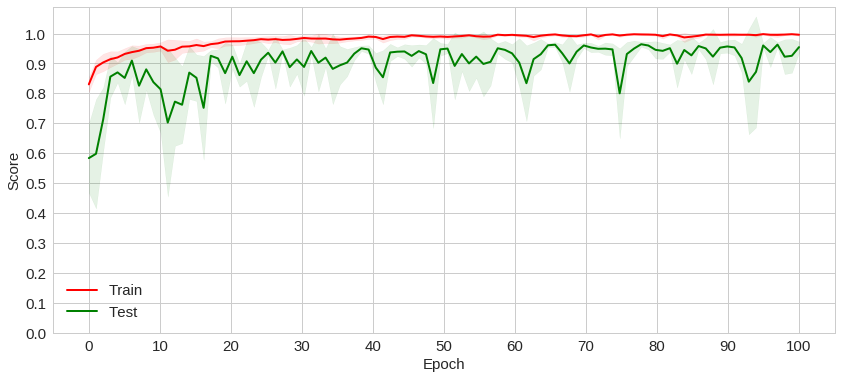

In [24]:
plot_mean_acc(hist)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

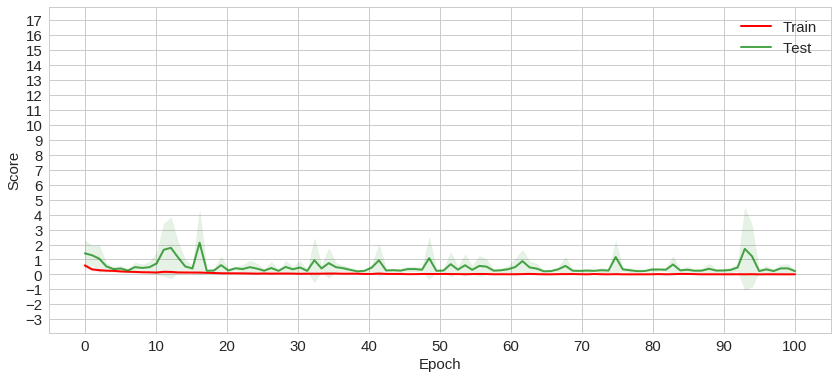

In [26]:
plot_mean_loss(hist)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean), np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean), np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-15, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

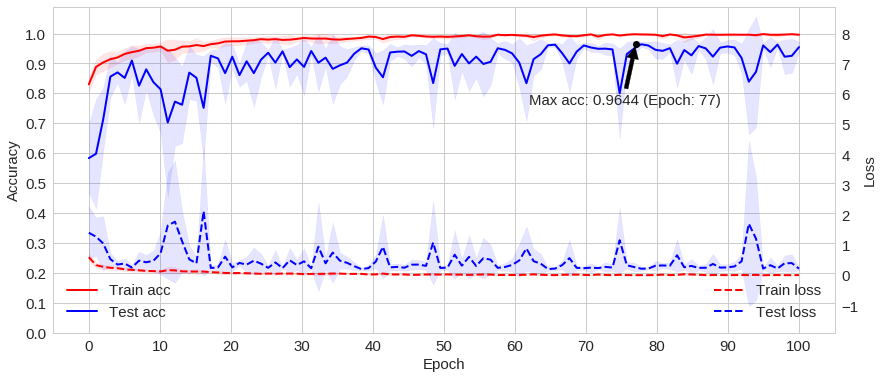

In [28]:
plot_mean(hist)